In [1]:


################################ GLOBAL VARIABLES ############################


########## DATA ##########
MODANET_ANNO = "modanet/annotations/modanet2018_instances_train.json"
MODANET_VAL = "modanet/annotations/modanet2018_instances_val.json"

PAPERDOLL_META_DB = "/root/product_image_segmentation/data/paperdoll/chictopia.sqlite3"
PAPERDOLL_IMG_DB = "/root/product_image_segmentation/data/paperdoll/photos.lmdb"
PAPERDOLL_IMG_SITE = "http://images2.chictopia.com"



########## MODEL ##########
JOB_NAME = "MODANET"
MODEL_TYPE = 'resnet50'
NUM_CATS = 13
IMAGE_SIZE = 512 #INPUT IMAGE SIZE : IMAGE_SIZE * IMAGE_SIZE

GPU_NUM = 1 #1# 2# 4# #8
IMAGES_PER_GPU_PER_IT = 4 #4 


STEPS_PER_EPOCH_NUM = 1000 #40000
VALIDATION_STEPS_NUM = 100


LR = 1e-4
#EPOCHS = [2, 4, 8, 16, 32, 64]
EPOCHS = [2, 4, 8, 9, 10, 11]

N_FOLDS = 5
SELECT_FOLD_IDX = 3


## pretrain data
FGVC6_WEIGHT_FIEL = "/root/product_image_segmentation/weight_files/mask_rcnn_FGVC6_0008.h5" 
LOG_DIR = "/root/product_image_segmentation/weight_files/logs"
###########################################################################
    


In [32]:
import json
from pycocotools.coco import COCO
import numpy as np
import skimage.io as imio
import matplotlib.pyplot as plt
import pylab



import io
import lmdb
import sqlite3
import pandas as pd
from PIL import Image
from IPython.display import display





In [12]:
access_str="file:"+PAPERDOLL_META_DB+"?mode=ro"
#db = sqlite3.connect('file:chictopia.sqlite3?mode=ro', uri=True)
meta_db = sqlite3.connect(access_str, uri=True)
photos = pd.read_sql("""
    SELECT
        *,
        'http://images2.chictopia.com/' || path AS url
    FROM photos
    WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
""", con=meta_db)
print('photos = %d' % (len(photos)))
photos.head()

photos = 1100987


,id,post_id,path,status,file_file_name,file_file_size,file_content_type,file_updated_at,width,height,created_at,updated_at,url
0,1,61,/photos/thefashbot/1930972049/1930972049_400.jpg,2,open-uri20120907-29328-3yd0mp,122564,image/jpeg,2012-09-07 23:07:38.719079,400,600,2012-09-07 23:07:38.441357,2012-09-07 23:07:39.456904,http://images2.chictopia.com//photos/thefashbo...
1,2,73,/photos/thefashbot/3613535083/3613535083_400.jpg,2,open-uri20120907-29328-1szdum6,119821,image/jpeg,2012-09-07 23:07:45.966209,400,600,2012-09-07 23:07:45.721208,2012-09-07 23:07:46.438801,http://images2.chictopia.com//photos/thefashbo...
2,3,73,/photos/thefashbot/3613535083/3420751783/34207...,2,open-uri20120907-29328-1uz77bi,115073,image/jpeg,2012-09-07 23:07:46.825511,400,600,2012-09-07 23:07:45.785651,2012-09-07 23:07:47.722063,http://images2.chictopia.com//photos/thefashbo...
3,4,85,/photos/thefashbot/10902372197/10902372197_400...,2,open-uri20120907-29328-1nqep2j,115259,image/jpeg,2012-09-07 23:07:53.314908,400,600,2012-09-07 23:07:52.920956,2012-09-07 23:07:54.329817,http://images2.chictopia.com//photos/thefashbo...
4,5,98,/photos/thefashbot/4328323416/4328323416_400.jpg,2,open-uri20120907-29328-10ax6ou,123235,image/jpeg,2012-09-07 23:08:00.645646,400,600,2012-09-07 23:08:00.081276,2012-09-07 23:08:01.889023,http://images2.chictopia.com//photos/thefashbo...


In [55]:
photo_meta_db = pd.read_sql("""
    SELECT
        *
    FROM photos
    WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
""", con=meta_db)
#http://images2.chictopia.com/photos/thefashbot/1930972049/1930972049_400.jpg


In [56]:
photo_meta_db.head()

,id,post_id,path,status,file_file_name,file_file_size,file_content_type,file_updated_at,width,height,created_at,updated_at
0,1,61,/photos/thefashbot/1930972049/1930972049_400.jpg,2,open-uri20120907-29328-3yd0mp,122564,image/jpeg,2012-09-07 23:07:38.719079,400,600,2012-09-07 23:07:38.441357,2012-09-07 23:07:39.456904
1,2,73,/photos/thefashbot/3613535083/3613535083_400.jpg,2,open-uri20120907-29328-1szdum6,119821,image/jpeg,2012-09-07 23:07:45.966209,400,600,2012-09-07 23:07:45.721208,2012-09-07 23:07:46.438801
2,3,73,/photos/thefashbot/3613535083/3420751783/34207...,2,open-uri20120907-29328-1uz77bi,115073,image/jpeg,2012-09-07 23:07:46.825511,400,600,2012-09-07 23:07:45.785651,2012-09-07 23:07:47.722063
3,4,85,/photos/thefashbot/10902372197/10902372197_400...,2,open-uri20120907-29328-1nqep2j,115259,image/jpeg,2012-09-07 23:07:53.314908,400,600,2012-09-07 23:07:52.920956,2012-09-07 23:07:54.329817
4,5,98,/photos/thefashbot/4328323416/4328323416_400.jpg,2,open-uri20120907-29328-10ax6ou,123235,image/jpeg,2012-09-07 23:08:00.645646,400,600,2012-09-07 23:08:00.081276,2012-09-07 23:08:01.889023


In [57]:
photo_meta_db['path'][396602]# 1 is the pic ID

'/photos/fashionimmersion/3837920277/5481439287/white-white-banana-republic-dress-dark-brown-brown-vintage-louis-vuitton-bag-_400.jpg'

In [49]:
#Photo data in LMDB

class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']
    
    
photo_data_set = PhotoData(PAPERDOLL_IMG_DB)
print(len(photo_data_set))

1097474


In [ ]:
for i in range(3):
    photo_meta = photo_meta_db.iloc[i]
    print(photo_meta)
    #print(photo_meta['post_id'])
    #print(photo.url)
    display(photo_data_set[photo_meta['id']])

In [19]:

# initialize COCO api for instance annotations
coco=COCO(MODANET_ANNO)




loading annotations into memory...
Done (t=5.87s)
creating index...
index created!


In [78]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(cats)
print(nms)
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

[{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}, {'supercategory': 'fashion', 'id': 2, 'name': 'belt'}, {'supercategory': 'fashion', 'id': 3, 'name': 'boots'}, {'supercategory': 'fashion', 'id': 4, 'name': 'footwear'}, {'supercategory': 'fashion', 'id': 5, 'name': 'outer'}, {'supercategory': 'fashion', 'id': 6, 'name': 'dress'}, {'supercategory': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'supercategory': 'fashion', 'id': 8, 'name': 'pants'}, {'supercategory': 'fashion', 'id': 9, 'name': 'top'}, {'supercategory': 'fashion', 'id': 10, 'name': 'shorts'}, {'supercategory': 'fashion', 'id': 11, 'name': 'skirt'}, {'supercategory': 'fashion', 'id': 12, 'name': 'headwear'}, {'supercategory': 'fashion', 'id': 13, 'name': 'scarf/tie'}]
['bag', 'belt', 'boots', 'footwear', 'outer', 'dress', 'sunglasses', 'pants', 'top', 'shorts', 'skirt', 'headwear', 'scarf/tie']
COCO categories: 
bag belt boots footwear outer dress sunglasses pants top shorts skirt headwear scarf/tie

COCO supercategorie

In [62]:
photo_meta_db.iloc[img['id']]


id                                                              401269
post_id                                                         256352
path                 /photos/fashionimmersion/3837920277/5481439287...
status                                                               2
file_file_name                          open-uri20120910-14596-1dfr25v
file_file_size                                                   53669
file_content_type                                           image/jpeg
file_updated_at                             2012-09-11 02:11:24.354232
width                                                              400
height                                                             600
created_at                                  2012-09-11 02:11:23.213836
updated_at                                  2012-09-11 02:11:24.813648
Name: 396602, dtype: object

In [65]:
print(type(photo_meta_db))
photo_meta_db.info()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100987 entries, 0 to 1100986
Data columns (total 12 columns):
id                   1100987 non-null int64
post_id              1100987 non-null int64
path                 1100987 non-null object
status               1100987 non-null int64
file_file_name       1100987 non-null object
file_file_size       1100987 non-null int64
file_content_type    1100987 non-null object
file_updated_at      1100987 non-null object
width                1100987 non-null int64
height               1100987 non-null int64
created_at           1100987 non-null object
updated_at           1100987 non-null object
dtypes: int64(6), object(6)
memory usage: 100.8+ MB


In [69]:
print(photo_meta_db['id'][img['id']])
print(img['id'])
print(photo_meta_db[photo_meta_db['id']==img['id']])

401269
396602
            id  post_id                                               path  \
392277  396602   148795  /photos/cynchmolina/9468333559/black-forever-2...   

        status                  file_file_name  file_file_size  \
392277       2  open-uri20120910-14596-1y727jk           99536   

       file_content_type             file_updated_at  width  height  \
392277        image/jpeg  2012-09-11 01:39:15.151887    400     600   

                        created_at                  updated_at  
392277  2012-09-11 01:39:14.342682  2012-09-11 01:39:15.827168  


In [114]:
# get all images containing given categories, select one at random
#catIds = coco.getCatIds(catNms=['bag','belt','shorts']);
catIds = coco.getCatIds(catNms=nms);
#imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [396602])

#img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
import os 
print(img)
print(img['id'])
photo_meta_db.iloc[i]
print(PAPERDOLL_IMG_SITE + photo_meta_db['path'][img['id']])
print(os.path.join(PAPERDOLL_IMG_SITE , photo_meta_db['path'][img['id']]))

{'file_name': '0396602.jpg', 'width': 400, 'id': 396602, 'license': 3, 'height': 600}
396602
http://images2.chictopia.com/photos/fashionimmersion/3837920277/5481439287/white-white-banana-republic-dress-dark-brown-brown-vintage-louis-vuitton-bag-_400.jpg
/photos/fashionimmersion/3837920277/5481439287/white-white-banana-republic-dress-dark-brown-brown-vintage-louis-vuitton-bag-_400.jpg


---->             id  post_id                                               path  \
392277  396602   148795  /photos/cynchmolina/9468333559/black-forever-2...   

        status                  file_file_name  file_file_size  \
392277       2  open-uri20120910-14596-1y727jk           99536   

       file_content_type             file_updated_at  width  height  \
392277        image/jpeg  2012-09-11 01:39:15.151887    400     600   

                        created_at                  updated_at  
392277  2012-09-11 01:39:14.342682  2012-09-11 01:39:15.827168  
width----> 400
height----> 600
path----> /photos/cynchmolina/9468333559/black-forever-21-shoes-off-white-striped-h-m-sweater-yellow-luce-alati-bag_400.jpg


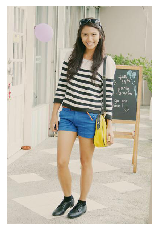

In [102]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
#I = imio.imread(PAPERDOLL_IMG_SITE + pics['path'][img['id']])

photo = photo_meta_db[photo_meta_db['id']==img['id']]

print("---->", photo)
print("width---->",photo['width'].values[0])
print("height---->",photo['height'].values[0])
print("path---->",photo['path'].values[0])
#I = imio.imread( photo['path'])
I = photo_data_set[img['id']]  ############################# get the image by image id
plt.axis('off')
plt.imshow(I)
plt.show()

In [111]:
print(type(photo_data_set))

<class '__main__.PhotoData'>


In [107]:
 for i, row in photo_meta_db.iterrows():
        print(row)
        if i > 2 :
            break

id                                                                  1
post_id                                                            61
path                 /photos/thefashbot/1930972049/1930972049_400.jpg
status                                                              2
file_file_name                          open-uri20120907-29328-3yd0mp
file_file_size                                                 122564
file_content_type                                          image/jpeg
file_updated_at                            2012-09-07 23:07:38.719079
width                                                             400
height                                                            600
created_at                                 2012-09-07 23:07:38.441357
updated_at                                 2012-09-07 23:07:39.456904
Name: 0, dtype: object
id                                                                  2
post_id                                                            

In [106]:
 for i, row in photo_meta_db.iterrows():
        print(i, row['id'])
        if i > 2 :
            break

0 1
1 2
2 3
3 4


[121030, 121031, 121032, 121033, 121034, 121035, 121036]
[{'segmentation': [[204, 50, 218, 48, 224, 40, 232, 46, 246, 48, 252, 44, 256, 55, 256, 47, 250, 36, 233, 31, 231, 36, 220, 33, 206, 33, 201, 36, 197, 47, 202, 47]], 'area': 1416, 'iscrowd': 0, 'image_id': 396602, 'bbox': [197, 31, 59, 24], 'category_id': 7, 'id': 121030}, {'segmentation': [[279, 136, 273, 148, 271, 225, 273, 290, 269, 308, 275, 326, 273, 362, 273, 373, 283, 383, 258, 390, 244, 388, 238, 376, 238, 360, 244, 332, 244, 311, 256, 292, 264, 288, 264, 234, 262, 183, 267, 136, 272, 135]], 'area': 11475, 'iscrowd': 0, 'image_id': 396602, 'bbox': [238, 135, 45, 255], 'category_id': 1, 'id': 121031}, {'segmentation': [[285, 136, 303, 167, 292, 207, 295, 243, 289, 246, 291, 265, 291, 314, 270, 309, 273, 288, 272, 222, 273, 147, 279, 136], [250, 296, 214, 290, 172, 279, 150, 272, 148, 267, 135, 264, 126, 266, 137, 219, 153, 157, 162, 130, 173, 118, 185, 116, 179, 140, 166, 160, 163, 198, 170, 206, 186, 185, 202, 172, 208, 1

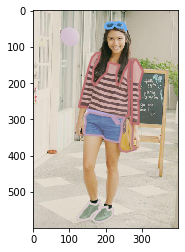

In [108]:

#photo_meta_db[photo_meta_db['id']==img['id']]

# load and display instance annotations
plt.imshow(I)
plt.axis('on')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)  #####get the anno by image id
print(annIds)
anns = coco.loadAnns(annIds)
print(anns)
coco.showAnns(anns)

print("--->", anns[0])
print("type --->", type(anns[0]))
print("image_id --->",anns[0]['image_id'])
"""
{'segmentation': [
    [204, 50, 218, 48, 224, 40, 232, 46, 246, 48, 252, 44, 256, 55, 256, 47, 250, 36, 233, 31, 231, 36, 220, 33, 206, 33, 201, 36, 197, 47, 202, 47]
    ], 
'area': 1416,
'iscrowd': 0, 
'image_id': 396602, 
'bbox': [197, 31, 59, 24], 
'category_id': 7, 
'id': 121030
}
"""
for xx in anns[0]['segmentation']:
    print("one polygan --->", xx)

for one in anns:
    print(one['category_id'])


# Train Model

In [37]:
import os
import io
import sys
import json
import datetime
import numpy as np
import skimage.draw

from pycocotools.coco import COCO
import skimage.io as imio
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold
import pylab
#from pathlib import Path

import lmdb
import sqlite3
import pandas as pd
from PIL import Image
from IPython.display import display


# Root directory of the project
LIB_ROOT_DIR = os.path.abspath("/root/product_image_segmentation/mask_rcnn_lib")
# Import Mask RCNN
sys.path.append(LIB_ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from tensorflow.contrib.tensorboard.plugins import projector


# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(LIB_ROOT_DIR, "../logs")

############################################################
#  Configurations
############################################################
#Photo data in LMDB

class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key) # binary image data
        if not data:
            return None
        
        with io.BytesIO(data) as f:
                image = Image.open(f).convert("RGB")
                image.load()
        return np.array(image)
        
        #return np.fromstring(data, dtype=np.uint8)
        #return np.frombuffer(data, dtype=np.uint8)
    
        #with io.BytesIO(data) as f:
        #    return np.frombuffer(f, dtype=np.uint8)
        
        #return skimage.io.imread(data)
        
        #with io.BytesIO(data) as f:
        #    image = Image.open(f)
        #    image.load()
        #    return image
        
    def __len__(self):
        return self.env.stat()['entries']
    
    

class ModaNetConfig(Config):
    def __init__(self, class_num=NUM_CATS, config_name=JOB_NAME):
        self.NUM_CLASSES = class_num + 1 # +1 for the background class
        self.NAME = config_name
        super().__init__()
        
    BACKBONE = MODEL_TYPE

    GPU_COUNT = GPU_NUM
    IMAGES_PER_GPU = IMAGES_PER_GPU_PER_IT 

    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = STEPS_PER_EPOCH_NUM

    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9
    


############################################################
#  Dataset
############################################################

class ModaNetDataset(utils.Dataset):

    """
    def __init__(self, photo_meta_db, annotation_file = MODANET_ANNO, 
                 image_dataset = PAPERDOLL_IMG_DB, 
                 website = PAPERDOLL_IMG_SITE):
        
        super().__init__(self)
        
        # initialize COCO api for instance annotations
        self.coco = COCO(annotation_file)
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.label_names = [cat['name'] for cat in cats]
        self.catIds = self.coco.getCatIds(catNms=self.label_names)
    """
    def __init__(self, photo_meta_db, coco, label_names, cat_ids,
                     image_dataset = PAPERDOLL_IMG_DB, 
                     website = PAPERDOLL_IMG_SITE):
        
        super().__init__(self)
        self.coco = coco
        self.label_names = label_names
        self.catIds = cat_ids
        #access_str = "file:" + sqlite_db + "?mode=ro"
        #meta_db = sqlite3.connect(access_str, uri=True)
        #self.photo_meta_db = pd.read_sql("""
        #    SELECT
        #        *
        #    FROM photos
        #    WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
        #""", con=meta_db)
        
        self.photo_meta_db = photo_meta_db

        
        self.photo_data_set = PhotoData(image_dataset)
        
        super(self.__class__, self).load_lmdb(self.photo_data_set)
        print(" ######### check list ######### ")
        print(" photo_meta_db size : ", len(self.photo_meta_db))
        print(" label_names : ", len(self.label_names))
        print(" catIds : ", len(self.catIds))
        print(" photo_meta_db size : ", len(self.photo_meta_db))
        print(" ############################## ")
              
    def load_all_dataset(self):
        # Add classes
        for i, name in enumerate(self.label_names):
            self.add_class("fashion", i+1, name)
            
        # Add images and annotations
        for i, row in self.photo_meta_db.iterrows():
            
            annIds = self.coco.getAnnIds(imgIds=row['id'], catIds=self.catIds, iscrowd=None)
            anns = self.coco.loadAnns(annIds)
            catids, polygons = [], []
            for one in anns:
                catids.append(one['category_id'])
                polygons.extend(one['segmentation'])
            
            if len(polygons) == 0:
                continue
                
            self.add_image("fashion", 
                           image_id = row['id'], 
                           #path = row['path'].values[0], 
                           path = row['path'], 
                           labels = catids,
                           polygons=polygons,
                           #annotations = polygons, 
                           #height=row['Height'].values[0], width=row['Width'].values[0])
                           height=row['height'], width=row['width'])
        print("load_all_dataset done, data size: " , self.get_stat())

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            all_points_x = []
            all_points_y = []
            idx = 0
            while idx < len(p):
                #all_points_x.append(p[0][idx])
                #all_points_y.append(p[0][idx+1])                
                all_points_x.append(p[idx])
                all_points_y.append(p[idx+1])
                idx += 2
                
            rr, cc = skimage.draw.polygon(all_points_y, all_points_x)
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        img_path = self.photo_meta_db['path'][image_id]
        if img_path.startswith("/"):
            return self.website + img_path
        return self.website + "/" + img_path
        #return self.photo_data_set[image_id]

    def get_stat(self):
        return super(self.__class__, self).get_image_list_size()
    

In [38]:
config = ModaNetConfig()
config.display()

access_str = "file:" + PAPERDOLL_META_DB + "?mode=ro"
meta_db = sqlite3.connect(access_str, uri=True)
photo_meta_db = pd.read_sql("""
            SELECT
                *
            FROM photos
            WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
        """, con=meta_db)




Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [39]:
coco = COCO(MODANET_ANNO)
print(coco.getCatIds())
#id_set = coco.getImgIds(catIds=coco.getCatIds())
cats = coco.loadCats(coco.getCatIds())
print(cats)
label_names = [cat['name'] for cat in cats]
print(label_names)
cat_ids = coco.getCatIds(catNms = label_names)
print(cat_ids)

img_id_set = []
for i in range(len(cat_ids)):
    img_id_set.extend(coco.getImgIds(catIds=[i]))
print("total annotation number: ", len(img_id_set))


loading annotations into memory...
Done (t=2.70s)
creating index...
index created!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}, {'supercategory': 'fashion', 'id': 2, 'name': 'belt'}, {'supercategory': 'fashion', 'id': 3, 'name': 'boots'}, {'supercategory': 'fashion', 'id': 4, 'name': 'footwear'}, {'supercategory': 'fashion', 'id': 5, 'name': 'outer'}, {'supercategory': 'fashion', 'id': 6, 'name': 'dress'}, {'supercategory': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'supercategory': 'fashion', 'id': 8, 'name': 'pants'}, {'supercategory': 'fashion', 'id': 9, 'name': 'top'}, {'supercategory': 'fashion', 'id': 10, 'name': 'shorts'}, {'supercategory': 'fashion', 'id': 11, 'name': 'skirt'}, {'supercategory': 'fashion', 'id': 12, 'name': 'headwear'}, {'supercategory': 'fashion', 'id': 13, 'name': 'scarf/tie'}]
['bag', 'belt', 'boots', 'footwear', 'outer', 'dress', 'sunglasses', 'pants', 'top', 'shorts', 'skirt', 'headwear', 'scarf/tie']


In [40]:
# drop  images with  no annotation
img_id_pd = pd.DataFrame({'id':img_id_set})
img_id_pd['id'] =img_id_pd['id'].apply(int)
photo_meta_db = pd.merge(photo_meta_db, img_id_pd, how='inner', on=['id'])
print("photo_meta_db size: ", len(photo_meta_db))

photo_meta_db size:  211828


In [41]:
print("category distribution: ")
for i in cat_ids:
    print(i, len(coco.getImgIds(catIds=[i])))

category distribution: 
1 20570
2 14295
3 7084
4 39222
5 23691
6 14426
7 8792
8 23015
9 34681
10 7031
11 13575
12 5446
13 5020


In [42]:

kf = KFold(n_splits=N_FOLDS, shuffle=True)
splits = kf.split(photo_meta_db) 

def get_fold(splits, train_df, idx):    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == idx:
            return train_df.iloc[train_index], train_df.iloc[valid_index]
        
train_df, valid_df = get_fold(splits, photo_meta_db, SELECT_FOLD_IDX)

print("train set size: " , len(train_df))
print("valid set size: " , len(valid_df))

train_dataset = ModaNetDataset(train_df, coco, label_names, cat_ids)
train_dataset.load_all_dataset()
train_dataset.prepare()


valid_dataset = ModaNetDataset(valid_df, coco, label_names, cat_ids)
valid_dataset.load_all_dataset()
valid_dataset.prepare()

print(train_dataset.get_stat())
print(valid_dataset.get_stat())

train set size:  169463
valid set size:  42365
 ######### check list ######### 
 photo_meta_db size :  169463
 label_names :  13
 catIds :  13
 photo_meta_db size :  169463
 ############################## 
load_all_dataset done, data size:  169463
 ######### check list ######### 
 photo_meta_db size :  42365
 label_names :  13
 catIds :  13
 photo_meta_db size :  42365
 ############################## 
load_all_dataset done, data size:  42365
169463
42365


In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOG_DIR)   

model.load_weights(FGVC6_WEIGHT_FIEL, by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

augmentation = iaa.Sequential([
    # orientation
    iaa.Fliplr(0.5),  
    #iaa.Fliplr(1),
    iaa.Flipud(0.5)
], random_order=True)


model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[0],
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0001

Checkpoint Path: /root/product_image_segmentation/weight_files/logs/modanet20190718T0807/mask_rcnn_modanet_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/2
  83/1000 [=>............................] - ETA: 55:42 - loss: 3.9194 - rpn_class_loss: 0.2341 - rpn_bbox_loss: 1.1481 - mrcnn_class_loss: 0.5051 - mrcnn_bbox_loss: 0.8592 - mrcnn_mask_loss: 1.1727

E0718 08:12:56.390592 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

  84/1000 [=>............................] - ETA: 55:28 - loss: 3.9110 - rpn_class_loss: 0.2355 - rpn_bbox_loss: 1.1518 - mrcnn_class_loss: 0.4998 - mrcnn_bbox_loss: 0.8569 - mrcnn_mask_loss: 1.1669

E0718 08:12:59.028363 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

  85/1000 [=>............................] - ETA: 55:14 - loss: 3.9027 - rpn_class_loss: 0.2368 - rpn_bbox_loss: 1.1551 - mrcnn_class_loss: 0.4947 - mrcnn_bbox_loss: 0.8548 - mrcnn_mask_loss: 1.1613

E0718 08:13:01.776565 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

  86/1000 [=>............................] - ETA: 55:02 - loss: 3.8944 - rpn_class_loss: 0.2380 - rpn_bbox_loss: 1.1582 - mrcnn_class_loss: 0.4897 - mrcnn_bbox_loss: 0.8528 - mrcnn_mask_loss: 1.1557

E0718 08:13:04.556460 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

  87/1000 [=>............................] - ETA: 54:48 - loss: 3.8859 - rpn_class_loss: 0.2391 - rpn_bbox_loss: 1.1609 - mrcnn_class_loss: 0.4848 - mrcnn_bbox_loss: 0.8507 - mrcnn_mask_loss: 1.1503

E0718 08:13:07.234764 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

  88/1000 [=>............................] - ETA: 54:36 - loss: 3.8771 - rpn_class_loss: 0.2402 - rpn_bbox_loss: 1.1634 - mrcnn_class_loss: 0.4800 - mrcnn_bbox_loss: 0.8485 - mrcnn_mask_loss: 1.1450

E0718 08:13:09.929092 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

  89/1000 [=>............................] - ETA: 54:23 - loss: 3.8584 - rpn_class_loss: 0.2389 - rpn_bbox_loss: 1.1570 - mrcnn_class_loss: 0.4760 - mrcnn_bbox_loss: 0.8467 - mrcnn_mask_loss: 1.1397

E0718 08:13:12.658492 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

  90/1000 [=>............................] - ETA: 54:11 - loss: 3.8401 - rpn_class_loss: 0.2377 - rpn_bbox_loss: 1.1507 - mrcnn_class_loss: 0.4722 - mrcnn_bbox_loss: 0.8449 - mrcnn_mask_loss: 1.1346

E0718 08:13:15.344459 139806809503488 model.py:1810] Error processing image {'id': 387355, 'source': 'fashion', 'path': '/photos/iamdenie/1689020736/9476125504/9476125504_400.jpg', 'labels': [2, 10, 9, 5, 4, 4], 'polygons': [[192, 186, 206, 193, 210, 193, 217, 195, 221, 197, 236, 200, 235, 205, 233, 207, 227, 210, 216, 205, 215, 207, 207, 207, 202, 199, 187, 192], [225, 216, 221, 224, 217, 230, 218, 233, 221, 234, 222, 237, 227, 239, 229, 239, 239, 241, 235, 247, 219, 241, 204, 241, 198, 241, 186, 239, 186, 232, 185, 227, 181, 224, 178, 208, 187, 209, 202, 214], [226, 216, 201, 213, 179, 207, 185, 200, 190, 194, 202, 200, 204, 205, 213, 207, 215, 206, 229, 211], [235, 200, 209, 193, 202, 191, 191, 186, 192, 162, 198, 154, 199, 147, 194, 128, 193, 124, 199, 129, 208, 131, 216, 131, 220, 131, 225, 126, 224, 111, 232, 130, 225, 155, 234, 169, 229, 184, 233, 190], [219, 100, 246, 109, 252, 137, 251, 147, 251, 155, 252, 160, 248, 158, 242, 159, 239, 168, 237, 204, 233, 196, 232, 190, 227, 1

 139/1000 [===>..........................] - ETA: 46:52 - loss: 3.4895 - rpn_class_loss: 0.2180 - rpn_bbox_loss: 1.1476 - mrcnn_class_loss: 0.3563 - mrcnn_bbox_loss: 0.7963 - mrcnn_mask_loss: 0.9713

E0718 08:15:27.995589 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 140/1000 [===>..........................] - ETA: 46:46 - loss: 3.4810 - rpn_class_loss: 0.2173 - rpn_bbox_loss: 1.1442 - mrcnn_class_loss: 0.3545 - mrcnn_bbox_loss: 0.7955 - mrcnn_mask_loss: 0.9694

E0718 08:15:30.647336 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 141/1000 [===>..........................] - ETA: 46:39 - loss: 3.4724 - rpn_class_loss: 0.2167 - rpn_bbox_loss: 1.1409 - mrcnn_class_loss: 0.3528 - mrcnn_bbox_loss: 0.7946 - mrcnn_mask_loss: 0.9675

E0718 08:15:33.356729 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 142/1000 [===>..........................] - ETA: 46:32 - loss: 3.4639 - rpn_class_loss: 0.2160 - rpn_bbox_loss: 1.1375 - mrcnn_class_loss: 0.3512 - mrcnn_bbox_loss: 0.7937 - mrcnn_mask_loss: 0.9656

E0718 08:15:36.057375 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 143/1000 [===>..........................] - ETA: 46:26 - loss: 3.4553 - rpn_class_loss: 0.2153 - rpn_bbox_loss: 1.1341 - mrcnn_class_loss: 0.3496 - mrcnn_bbox_loss: 0.7926 - mrcnn_mask_loss: 0.9636

E0718 08:15:38.758439 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 144/1000 [===>..........................] - ETA: 46:19 - loss: 3.4465 - rpn_class_loss: 0.2146 - rpn_bbox_loss: 1.1307 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.7915 - mrcnn_mask_loss: 0.9617

E0718 08:15:41.449347 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 145/1000 [===>..........................] - ETA: 46:13 - loss: 3.4408 - rpn_class_loss: 0.2145 - rpn_bbox_loss: 1.1290 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.7912 - mrcnn_mask_loss: 0.9598

E0718 08:15:44.189540 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 146/1000 [===>..........................] - ETA: 46:07 - loss: 3.4351 - rpn_class_loss: 0.2143 - rpn_bbox_loss: 1.1274 - mrcnn_class_loss: 0.3447 - mrcnn_bbox_loss: 0.7909 - mrcnn_mask_loss: 0.9578

E0718 08:15:46.873731 139806809503488 model.py:1810] Error processing image {'id': 198581, 'source': 'fashion', 'path': '/photos/watermoolen/10875708132/white-cotton-on-vest-blue-olsenboyle-shorts-brown-thrifted-belt-brown-stev_400.jpg', 'labels': [9, 2, 10, 3, 3, 1], 'polygons': [[218, 191, 215, 213, 200, 218, 180, 219, 158, 211, 151, 209, 154, 184, 149, 191, 150, 220, 149, 251, 151, 271, 155, 279, 150, 293, 149, 300, 164, 308, 172, 307, 180, 308, 192, 308, 199, 308, 216, 295, 223, 289, 214, 283, 220, 246, 220, 214, 223, 196], [214, 299, 201, 306, 192, 309, 182, 309, 173, 307, 161, 307, 150, 299, 146, 312, 158, 322, 167, 328, 184, 326, 199, 332, 217, 331, 216, 322, 207, 317, 219, 310], [210, 334, 188, 328, 175, 329, 166, 326, 160, 321, 148, 311, 139, 345, 138, 353, 125, 364, 125, 386, 152, 389, 175, 387, 182, 387, 215, 390, 225, 382, 217, 362, 224, 341, 222, 316, 217, 311, 210, 318, 218, 328, 212, 332], [208, 498, 199, 505, 184, 500, 181, 494, 179, 512, 178, 524, 176, 568, 182, 579, 1

 221/1000 [=====>........................] - ETA: 39:43 - loss: 3.1589 - rpn_class_loss: 0.2018 - rpn_bbox_loss: 1.0526 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.7630 - mrcnn_mask_loss: 0.8560